# Psyplot with cfgrib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [3]:
import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")
warnings.filterwarnings("ignore", r"\s*ShapelyDeprecationWarning")

In [4]:
f_icon_irr = '/scratch/walser/icon-vis/icon-1/21112300.grb2/lfff00000000'
f_icon_reg = '/store/s83/tsm/ICON-1E/FCST21/21112300_606/grib/i1effsurf000_001'
f_cosmo = '/store/s83/osm/KENDA-1/ANA21/det/laf2021112300'

gridfile='/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'


## 1.0 Open GRIB2 file with gridfile argument in psy.open_dataset - doesn't appear to work.

In [5]:
ds_cfgrib_withgridfile = psy.open_dataset(f_icon_irr, decode_cf=True, gridfile=gridfile, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})

#### Encoding.coordinates is not correct and so won't plot lon and lat on the axis.

In [6]:
ds_cfgrib_withgridfile.t2m.encoding

{'source': '/scratch/walser/icon-vis/icon-1/21112300.grb2/lfff00000000',
 'filter_by_keys': {},
 'encode_cf': ('parameter', 'time', 'geography', 'vertical'),
 'original_shape': (1028172,),
 'dtype': dtype('float32'),
 'coordinates': 'number time step heightAboveGround valid_time'}

In [7]:
#figure1 = ds_cfgrib_withgridfile.psy.plot.mapplot(
#    name="t2m", xgrid='None',  ygrid='None'
#)

## 2.0 Open GRIB2 file using psy.open_dataset with cfgrib engine

In [8]:
ds_cfgrib = psy.open_dataset(f_icon_irr, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})

## 2.1 Open the corresponding R19B08 Grid for the GRIB file:
(No engine neeeded, engine only needed for grid files.)

In [9]:
ds_grid = psy.open_dataset(gridfile)

## 2.2 Combine GRID file with GRIB2 file, to have coordinates from GRID file with the GRIB data.

In [10]:
def openfiles(file, gridfile):
    ds_cfgrib = psy.open_dataset(file, engine='cfgrib',  backend_kwargs={'indexpath': '', 'errors': 'ignore'})
    ds_grid = psy.open_dataset(gridfile)
    return ds_cfgrib, ds_grid

In [11]:
# TODO: remove a lot of the un-needed steps in this function since these were experimental, 
# and now we know they are not all required for the plots.

def combine_grib_grid(file, grid):
    
    result = file.rename({'time': 'init_time','valid_time': 'time'}
                        ).rename_dims({'values':'ncells'}
                        ).assign_coords(
                        clon=('ncells', np.float32(grid.coords['clon'].values))
                        ).assign_coords(
                        clat=('ncells', np.float32(grid.coords['clat'].values))
                        ).assign_coords(
                        clat_bnds=(('ncells','vertices'), np.float32(grid.coords['clat_vertices'].values))
                        ).assign_coords(
                        clon_bnds=(('ncells','vertices'), np.float32(grid.coords['clon_vertices'].values))
                        ).expand_dims('time')
    
    result.clon.attrs['standard_name']='longitude'
    result.clon.attrs['long_name']='center longitude'
    result.clon.attrs['units']='radian'
    result.clon.attrs['bounds']='clon_bnds'
    result.clat.attrs['standard_name']='latitude'
    result.clat.attrs['long_name']='center latitude'
    result.clat.attrs['units']='radian'
    result.clat.attrs['bounds']='clat_bnds'

    result.time.attrs['axis']='T'
    #result.generalVerticalLayer.attrs['positive']='up'
    #result.generalVerticalLayer.attrs['axis']='Z'
    
    return result

In [12]:
ds_cfgrib, ds_grid = openfiles(f_icon_irr, gridfile)
ds_cfgrib_combi = combine_grib_grid(ds_cfgrib, ds_grid)

#### Simplified merging shown below

In [13]:
#ds = psy.open_dataset(f_icon_irr, engine="cfgrib")
#grid_ds = psy.open_dataset(gridfile)
#merged = ds.rename({"values": "cell"}).merge(grid_ds)
#merged.t2m.encoding["coordinates"] += " clon clat"

### Coordinate encoding of variables remains incorrect, must be corrected.

In [14]:
print(ds_cfgrib_combi.t.encoding['coordinates'])

number time step generalVerticalLayer valid_time


In [15]:
ds_cfgrib_combi.t.encoding['coordinates'] = 'clon clat'
print(ds_cfgrib_combi.t.encoding['coordinates'])

clon clat


In [16]:
import six

def add_encoding(obj):
    obj.encoding['coordinates'] = 'clat clon'
    
for k, v in six.iteritems(ds_cfgrib_combi.data_vars):
    add_encoding(v)

### Now the variables are ready to be plotted.

In [17]:
ds_cfgrib_combi

<xarray.Dataset>
Dimensions:               (ncells: 1028172, generalVerticalLayer: 80, depthBelowLandLayer: 8, depthBelowLand: 9, generalVertical: 81, vertices: 3, time: 1)
Coordinates: (12/25)
    number                int64 ...
    init_time             datetime64[ns] ...
    step                  timedelta64[ns] ...
    surface               float64 ...
  * time                  (time) datetime64[ns] 2021-11-23
    isobaricLayer         float64 ...
    ...                    ...
  * depthBelowLand        (depthBelowLand) float64 0.0 0.005 0.02 ... 4.86 14.58
  * generalVertical       (generalVertical) float64 1.0 2.0 3.0 ... 80.0 81.0
    clon                  (ncells) float32 -0.003694 -0.003783 ... 0.2608 0.2607
    clat                  (ncells) float32 0.8636 0.8635 0.8632 ... 0.868 0.8679
    clat_bnds             (ncells, vertices) float32 0.8635 0.8637 ... 0.8678
    clon_bnds             (ncells, vertices) float32 -0.003566 ... 0.2605
Dimensions without coordinates: ncells, vertices
Data variables: (12/70)
    snfalb                (time, ncells) float32 0.07 0.07 ... 0.1171 0.1179
    lhtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    nlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dlwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ulwrf                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    shtfl                 (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                    ...
    sd                    (time, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    W_SO                  (time, depthBelowLandLayer, ncells) float32 0.0 ......
    W_SO_ICE              (time, depthBelowLandLayer, ncells) float32 0.0 ......
    wz                    (time, generalVertical, ncells) float32 -0.009946 ....
    THHR_RAD              (time, generalVerticalLayer, ncells) float32 1.237e...
    SOHR_RAD              (time, generalVerticalLayer, ncells) float32 0.0 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Zurich
    history:                 2022-02-04T10:23 GRIB to CDM+CF via cfgrib-0.9.9...

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


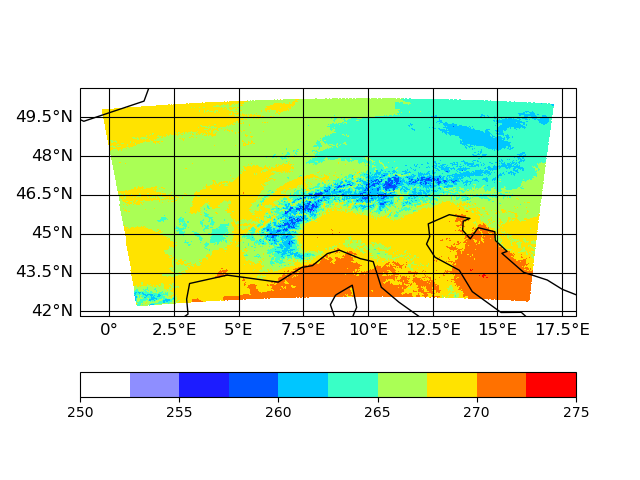

In [18]:
newfigure2_2 = ds_cfgrib_combi.psy.plot.mapplot(
    name="t", generalVerticalLayer=50, time=0
)

In [19]:
# newfigure.update(datagrid={'c': 'k', 'lw': 0.1})
newfigure2_2.update(cmap='Reds', datagrid=None, xgrid='None',  ygrid='None')
newfigure2_2.update(clabel='{desc}')
newfigure2_2.update(title=(f"{ds_cfgrib_combi.t.attrs['GRIB_name']} on "
                        f"{ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']} " 
                        f"%({ds_cfgrib_combi.t.attrs['GRIB_typeOfLevel']})s "
                        f"at %(time)s ")
                )

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


## 3.0 Custom Plotter and FormatOptions

In [20]:
from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D, LonLatBox, MapPlotter
from psyplot.plotter import Plotter
import psy_simple.plotters
import psy_maps.plotters
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/scratch/vcherkas/envs/

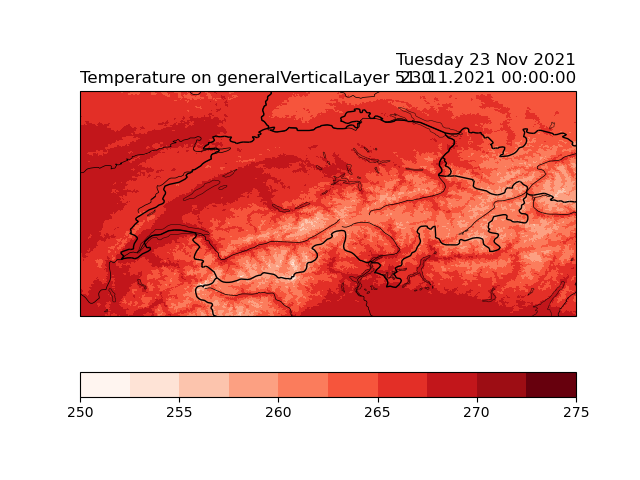

In [22]:
from formatoptions import Borders, CustomText, Rivers, Lakes, StandardTitle, MeanMaxWind

newfigure1 = ds_cfgrib_combi.psy.plot.mapplot(
    name="t", generalVerticalLayer=50, time=0, borders=True, cmap='Reds', rivers=True, lakes=True,
    standardtitle=True,
    map_extent=[5.5, 11.0, 45.5, 48.0], xgrid=None, ygrid=None
)

In [ ]:
#newfigure1.update(customtext=False, standardtitle=False, xgrid=None, ygrid=None, rivers=True, map_extent=[5.5, 11.0, 45.5, 48.0])

### Remap ICON grid to Regular grid for wind plotting

#### First using dwd icon tools

In [ ]:
from utils import ICONtoReg_icontools

f_icon_nc = '/scratch/walser/icon-vis/icon-1/21112300.nc/lfff00000000z'
f_icon_nc_grid = '/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'

output_file = ICONtoReg_icontools.remap_ICON_to_Regulargrid(data_file=f_icon_nc, 
                                                            grid_file=f_icon_nc_grid, 
                                                            init_type="netcdf2")

mapvectors = psy.plot.mapvector(output_file, time=0,
                                map_extent=[5.5, 11.0, 45.5, 48.0], 
                                name=[['U', 'V']],
                                density=15, arrowsize=100, borders=True)

#### Second using fieldextra

/scratch/vcherkas/envs/psyplot/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


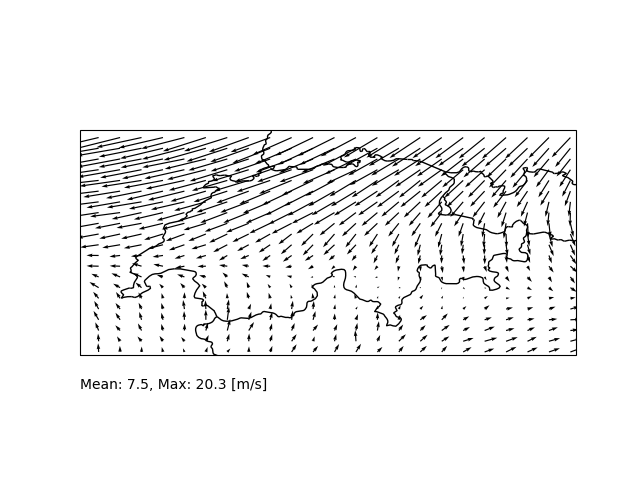

In [23]:
from utils import ICONtoReg_fieldextra
from formatoptions import MeanMaxWind

f_icon_nc = "/scratch/vcherkas/psyplot/fieldextra_sandbox/sandbox/fromJeanMarie/lfff00000000z"
f_icon_nc_grid = '/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'

output_file = ICONtoReg_fieldextra.remap_ICON_to_Regulargrid(data_file=f_icon_nc,
                                        grid_file=f_icon_nc_grid,
                                        num_dates=2)

mapvectors = psy.plot.mapvector(output_file, time=0,
                                map_extent=[5.5, 11.0, 45.5, 48.0], 
                                name=[['U', 'V']],
                                density=15, arrowsize=200, z_1=8, 
                                borders=True, xgrid=None, ygrid=None, meanmax_wind=True)

In [ ]:
ds_grid = psy.open_dataset(output_file)
ds_grid

### Remap ICON grid to courser ICON grid for wind plotting

In [ ]:
from utils import ICONgrid_lowres_fieldextra

f_icon_nc = "/scratch/vcherkas/psyplot/fieldextra_sandbox/sandbox/fromJeanMarie/lfff00000000z"
f_icon_nc_grid = '/scratch/cmerker/data/icon_grid/icon_grid_0001_R19B08_L.nc'

output_file_2 = ICONgrid_lowres_fieldextra.remap_ICON_to_lowresICON(data_file=f_icon_nc,
                                        grid_file=f_icon_nc_grid,
                                        num_dates=2)

ds_grid_2 = psy.open_dataset(output_file_2)

In [ ]:
ds_grid_2 = ds_grid_2.rename_dims({'values':'ncells'})
ds_grid_2 = ds_grid_2.rename({'time': 'init_time','valid_time': 'time'})
ds_grid_2

In [ ]:
print(np.shape(ds_grid_2.U))
print(np.shape(ds_grid_2.V))
print(np.shape(ds_grid_2.clon))
print(np.shape(ds_grid_2.clat))

In [ ]:
ds_grid_2.x.shape


In [ ]:

mapvectors = ds_grid_2.psy.plot.mapvector(
                                name=[['u', 'v']]
                               )



## 4.0 Combined Mapplot - Wind + Temperature

In [ ]:
newfigure4 = ds_cfgrib_combi.psy.plot.mapcombined(
            name=[['t',['u','v']]], 
            generalVerticalLayer=50, time=0, datagrid={'c': 'k', 'lw': 0.1}, xgrid=None, ygrid=None,
            borders=True, 
            cmap='Reds', 
            arrowsize=100, 
            vcbar='r',
            clabel='{desc}', 
            vclabel='Wind Speed [%(units)s]',
            map_extent=[6.85, 7.0, 46.7, 46.75]
            )

## Appendix
### Notes to consider with psyplot

 *  _NETCDF_ note: If your .nc file is missing the grid-information, this has to be added (merged) from the grid-file which had been used to run the simulation. This would be the case if you ran icon with the output_nml:output_grid flag set to .FALSE. (which appears to be the default ICON setting).

* It may also be necessary in this case to add coordinates encoding to the variable you want to plot eg. for athb_s: `ds.athb_s.encoding.update(coordinates="clon clat")`


### Work In Progress

#### Plot data from multiple datasets, on different grids. 

In [ ]:
wind_data = psy.open_dataset(output_file)
wind_data.U

In [ ]:
from psyplot.data import InteractiveList

data=InteractiveList([ds_cfgrib_combi.t, wind_data.U, wind_data.V])

data[1]

In [ ]:
from psyplot.data import InteractiveList
combined = psy_maps.plotters.CombinedPlotter(data=InteractiveList([ds_cfgrib_combi.t2m, wind_data.U, wind_data.V]))

In [ ]:
combined = psy.plot.mapcombined(
    ds_cfgrib_combi, name=[['t2m',['u','v']]], clabel='{desc}', arrowsize=100,
    cmap='RdBu_r', ax=None, title='scalar and vector field')

In [ ]:
icon_grid_demo='/scratch/vcherkas/psyplot/psyplot-DKRZ-TechTalk-20201117/data/icon_grid_demo.nc'
ds_icon_grid_demo = psy.open_dataset(icon_grid_demo)
ds_icon_grid_demo

In [ ]:
icon_grid_demo='/scratch/vcherkas/psyplot/psyplot-DKRZ-TechTalk-20201117/data/icon_grid_demo.nc'

maps = psy.plot.mapplot(icon_grid_demo, name='t2m_edge', projection='robin',
                        datagrid=dict(c='b', lw=0.2), #standardTitle=True
                       )